In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from nltk.tokenize import TweetTokenizer
porter = nltk.PorterStemmer()
lancaster = nltk.LancasterStemmer()
import re
import sys
sys.path.insert(0, '../')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.sparse import coo_matrix, hstack
import matplotlib.pyplot as plt
import seaborn as sn
import scipy
from scipy.sparse import coo_matrix, hstack

In [2]:
data = pd.read_csv('../data/tweets_public.csv', sep = ",", encoding = "utf-8")

FileNotFoundError: File b'../data/tweets_public.csv' does not exist

In [3]:
data["users"] = data["text"].map(lambda x: re.findall("@([A-Za-z0-9_]+)", x)) # extract usernames
data["hashtags"] = data["text"].map(lambda x: re.findall("#([A-Za-z0-9_]+)", x)) # extract hashtags

data["text_without_punct"] = data['text'].apply(lambda x: re.sub(r'[^\w\s]','',x)) # eliminate all punctuation
data["text_without_numericals"] = data['text_without_punct'].str.replace('\d+', '')


data['tweet_without_stopwords'] = data['text_without_numericals']\
.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) # removing stopwords

tt = TweetTokenizer()
data['list_of_words'] = data['tweet_without_stopwords'].apply(tt.tokenize) # tokenize text

data["words_list_porter"] = data["list_of_words"].apply(lambda x:[porter.stem(y) for y in x]) # stemmer porter
data["words_list_lancaster"] = data["list_of_words"].apply(lambda x:[lancaster.stem(y) for y in x]) # stemmer lancaster
data["words_lancaster"] = data['words_list_lancaster'].apply(lambda x: ' '.join(x)) #convert list to string, so TfidfVectorizer can eat it
data["words_porter"] = data['words_list_porter'].apply(lambda x: ' '.join(x))

data.iloc[2]

tweet_id                                                       569506670189137920
airline_sentiment                                                        negative
airline_sentiment_confidence                                               0.6473
negativereason                                                       Lost Luggage
negativereason_confidence                                                  0.6473
airline                                                                    United
airline_sentiment_gold                                                        NaN
name                                                                  szymanski_t
negativereason_gold                                                           NaN
retweet_count                                                                   0
text                            @united if you lost my belongings then BE HONEST!
tweet_coord                                                                   NaN
tweet_created   

In [5]:
data1 = data.drop_duplicates(subset='text')

In [8]:
# adding length to the feature space
cv = CountVectorizer(max_features=200)

X_cv = cv.fit_transform(data['words_lancaster'])

data['length'] = data['text'].apply(len)
length = data["length"].values
length1 = np.asmatrix(length)
length2 = length1.transpose()
sparse_matrix = scipy.sparse.csr_matrix(length2)

Y = data['airline_sentiment'].values

my_features = hstack((X_cv, sparse_matrix)) # np.hstack creates an array of the two matrices!!!
my_features.shape
X_train, X_test, y_train, y_test = train_test_split(my_features, Y, test_size=0.4, random_state=0)   

In [9]:
# testing results after having the new features added
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)

[ 0.72417062  0.73149905  0.74857685  0.75237192  0.72649573]


In [10]:
# confusion matrix 
# https://stackoverflow.com/questions/20927368/python-how-to-normalize-a-confusion-matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=["positive", "negative", "neutral"])
cm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
cm

array([[ 0.57733813,  0.24460432,  0.17805755],
       [ 0.04682575,  0.8374606 ,  0.11571364],
       [ 0.11804613,  0.35956581,  0.52238806]])

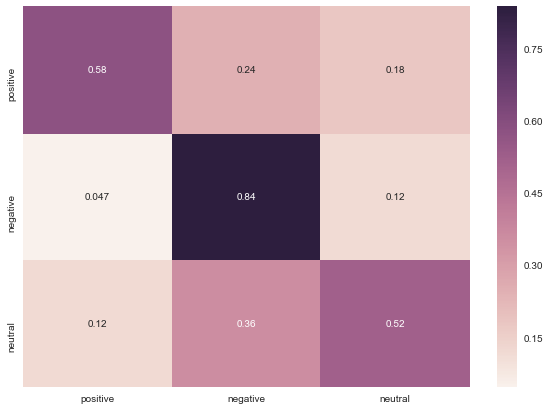

In [11]:
# confusion matrix
%matplotlib inline
df_cm = pd.DataFrame(cm, index = ["positive", "negative","neutral"], columns = ["positive", "negative","neutral"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True);

In [12]:
# try TfidfVectorizer on not deduplicated dataset

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words = "english", max_features = 200)

train, test = train_test_split(data, test_size=0.25)
cv = vectorizer

x_train = cv.fit_transform(train['words_lancaster'])
y_train = train['airline_sentiment'].values

x_test = cv.transform(test['words_lancaster'])
y_test = test['airline_sentiment'].values

from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

#print(accuracy_score(y_test, y_pred))
scores = cross_val_score(model, x_train, y_train, cv=5)
print(scores)

[ 0.75435936  0.73141123  0.74279211  0.7357631   0.72340426]


In [13]:
# try TfidfVectorizer on deduplicated dataset

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words = "english", max_features = 200)

train, test = train_test_split(data1, test_size=0.25)
cv = vectorizer

x_train = cv.fit_transform(train['words_lancaster'])
y_train = train['airline_sentiment'].values

x_test = cv.transform(test['words_lancaster'])
y_test = test['airline_sentiment'].values

from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

#print(accuracy_score(y_test, y_pred))
scores = cross_val_score(model, x_train, y_train, cv=5)
print(scores)

[ 0.73873186  0.72915073  0.74578867  0.73047473  0.74272588]
